In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
sys.path.insert(0, parent_dir)


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import invgamma
import utils
import hashlib
from sklearn.mixture import GaussianMixture
from mixtureModels import DiagGaussianFS
from mixtureModels import DiagGaussianCategorical
from sklearn.metrics.cluster import adjusted_rand_score
import time
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import multiprocessing
import os

## Dataset Generation

In [3]:
N = 1000
K = 3
gD = 4
cD = 4
M = 3

# seed = 47238
# seed = 37620
# seed = np.random.randint(1000, 2**16)
seed = 16765
seed = 28940
print(seed)
np.random.seed(seed)

N_noisey_features = 0
data_dir = "thesisResCatGaussData"
filenames = []

if not data_dir in os.listdir():
    os.mkdir(data_dir)

m0_true = np.random.uniform(2, 4, (K, gD))
k0_true = np.random.uniform(3, 5, K)
S0_true = np.random.uniform(0, 0.1, (K, gD))
v0_true = np.random.randint(4, 8, K)

a, b = [0.15, 0.45]

categorical_Ms = M + np.zeros(cD, int)

alpha_true = 1.0

mixing_probabilities = np.random.dirichlet([alpha_true]*K, size=1)[0]
z_true = np.random.choice(K, p=mixing_probabilities, size=N)

## Generate Gaussian data
mu = np.zeros((K, gD), float)
sigma = np.zeros((K, gD), float)
for k in range(K):
    for j in range(gD):
        mu[k, j] = norm.rvs(m0_true[k, j], S0_true[k, j]/(k0_true[k]*v0_true[k]))
        sigma[k, j] = invgamma.rvs(v0_true[k]/2, S0_true[k, j]/2)
X = np.zeros((N, gD))

for i in range(N):
    for j in range(gD):
        for k in range(K):
            if z_true[i] == k:
                X[i, j] = np.random.normal(mu[k, j], sigma[k, j])


## Generate Categorical data
alpha_Ks = np.zeros((cD, K), float)
C = np.zeros((N, cD), int)

for i in range(cD):
    alpha_K = 0.001* np.random.randint(1000*a, 1000*b, K)
    alpha_Ks[i, :] = alpha_K
    categorical_M = categorical_Ms[i]
    categorical_data = np.zeros(N, int)
    for k in range(K):
        dirichletSample_prob = np.random.dirichlet(alpha_K[k] + np.zeros(categorical_M), size=1)[0]
        categorical_data[np.where(z_true == k)] = np.random.choice(categorical_M, p = dirichletSample_prob, size=z_true.tolist().count(k))
    
    C[:, i] = categorical_data
    

for i_feature in range(N_noisey_features+1):

    isLOCAL = False # global or local
    true_features_g = np.ones((K, gD + i_feature), int)
    true_features_c = np.ones((K, cD + i_feature), int)
    
    if not isLOCAL:
        true_features_c[:, :i_feature] = np.zeros((K, i_feature), int)
        true_features_g[:, :i_feature] = np.zeros((K, i_feature), int)
    
    else:
        for j in range(i_feature):
            rand_cluster = np.random.randint(0, 2, K)
            true_features[:, j] = rand_cluster
    
    
    X_noisey = np.concatenate((np.zeros((N, i_feature)), X.copy()), axis = 1)
    C_noisey = np.concatenate((np.zeros((N, i_feature), int), C.copy()), axis = 1)

    
    X_mean = np.mean(X)
    X_var = np.var(X)
    for k in range(K):
        for j in range(gD+i_feature):
            if true_features_g[k][j] == 0:
                for i in range(N):
                    if z_true[i] == k:
                        X_noisey[i, j] = np.random.normal(X_mean, 3*X_var)
                        
    for k in range(K):
        for j in range(cD+i_feature):
            if true_features_c[k][j] == 0:
                for i in range(N):
                    if z_true[i] == k:
                        C_noisey[i, j] = np.random.randint(0, M)

    filename = f"{N}_{K}_{gD}_{cD}_{seed}_{hashlib.sha256(X_noisey.tobytes()).hexdigest()[:3]}_{hashlib.sha256(C_noisey.tobytes()).hexdigest()[:3]}_{i_feature}"
    filenames.append(filename)
    
    filepath = f"{data_dir}/{filename}"
    print(utils.saveData(f"{filepath}.gauss.csv", X_noisey, remark="Data"))
    print(utils.saveData(f"{filepath}.cat.csv", C_noisey, remark="Data"))
    print(utils.saveData(f"{filepath}.labels", z_true, remark="Labels"))


28940
thesisResCatGaussData/1000_3_4_4_28940_0aa_bb4_0.gauss.csv
thesisResCatGaussData/1000_3_4_4_28940_0aa_bb4_0.cat.csv
thesisResCatGaussData/1000_3_4_4_28940_0aa_bb4_0.labels


In [13]:
# for filename in filenames:
#     X = utils.extractData(f"{data_dir}/{filename}.gauss.csv", "data")
#     C = utils.extractData(f"{data_dir}/{filename}.cat.csv", "data_int")
#     # print(filename)
#     # heatmap = sns.heatmap(X[np.argsort(z_true)])
#     heatmap = sns.heatmap(C[np.argsort(z_true)])
#     plt.show()
#     plt.close()

## Models

In [21]:
## Run scikit GMM with no noisey data

def runEM(filename):
    
    print(f"\n{filename}")

    start_time = time.process_time()
    training_runs_EM = 2
    EM_gmm = GaussianMixture(n_components=K, n_init=training_runs_EM)
    X = utils.extractData(f"{data_dir}/{filename}.gauss.csv", "data")
    C = utils.extractData(f"{data_dir}/{filename}.cat.csv", "data_int")
    one_hot_C = np.zeros((N, cD*M))
    encoder = OneHotEncoder(sparse=False)
    one_hot_C = encoder.fit_transform(C)
    mixed_data_one_hot = np.concatenate((X, one_hot_C), axis=1)
    EM_gmm.fit(mixed_data_one_hot)
    
    print(f"BIC: {EM_gmm.bic(mixed_data_one_hot)}\nK: {K}")
    z_pred_EM = EM_gmm.predict(mixed_data_one_hot)
    utils.saveData(f"out{data_dir}/{filename}.pred.em.labels", z_pred_EM, "labels")
    utils.saveData(f"out{data_dir}/{filename}.pred.em.time", time.process_time() - start_time, "single")



def runBayes(filename):

    print(f"\n{filename}")

    start_time = time.process_time()
    X = utils.extractData(f"{data_dir}/{filename}.gauss.csv", "data")
    C = utils.extractData(f"{data_dir}/{filename}.cat.csv", "data_int")
    print(X[0], C[0])
    
    est = DiagGaussianCategorical(alpha = 1.0, m_0_partial = 0, k_0 = 0.03, v_0_partial = 3, S_0_partial = 0.3, gamma = 0.2, K_initial = 3, iterations=30, runs = 2, seed = 8926823)
    
    est.sample(X, C)
    bayes_pred = est.assignments()
    utils.saveData(f"out{data_dir}/{filename}.pred.bayes.labels", bayes_pred, "labels")
    utils.saveData(f"out{data_dir}/{filename}.pred.bayes.time", time.process_time() - start_time, "single")



def runBayesGauss(filename):
    
    print(f"\n{filename}")

    start_time = time.process_time()
    
    X = utils.extractData(f"{data_dir}/{filename}.gauss.csv", "data")
    C = utils.extractData(f"{data_dir}/{filename}.cat.csv", "data_int")
    one_hot_C = np.zeros((N, cD*M))
    encoder = OneHotEncoder(sparse=False)
    one_hot_C = encoder.fit_transform(C)
    mixed_data_one_hot = np.concatenate((X, one_hot_C), axis=1)
    
    est = DiagGaussianFS(alpha = 1.0, m_0_partial = 0, k_0 = 0.03, v_0_partial = 3, S_0_partial = 0.3, K_initial = K, iterations=30, runs = 2)
    est.sample(mixed_data_one_hot)
    bayes_pred = est.assignments()
    utils.saveData(f"out{data_dir}/{filename}.pred.bayes.gauss.labels", bayes_pred, "labels")
    utils.saveData(f"out{data_dir}/{filename}.pred.bayes.gauss.time", time.process_time() - start_time, "single")



def runEM_diag(filename):
    
    print(f"\n{filename}")

    start_time = time.process_time()
    training_runs_EM = 2
    EM_gmm = GaussianMixture(n_components=K, n_init=training_runs_EM, covariance_type = "diag")
    X = utils.extractData(f"{data_dir}/{filename}.gauss.csv", "data")
    C = utils.extractData(f"{data_dir}/{filename}.cat.csv", "data_int")
    one_hot_C = np.zeros((N, cD*M))
    encoder = OneHotEncoder(sparse=False)
    one_hot_C = encoder.fit_transform(C)
    mixed_data_one_hot = np.concatenate((X, one_hot_C), axis=1)
    EM_gmm.fit(mixed_data_one_hot)
    
    print(f"BIC: {EM_gmm.bic(mixed_data_one_hot)}\nK: {K}")
    z_pred_EM = EM_gmm.predict(mixed_data_one_hot)
    utils.saveData(f"out{data_dir}/{filename}.pred.em_diag.labels", z_pred_EM, "labels")
    utils.saveData(f"out{data_dir}/{filename}.pred.em_diag.time", time.process_time() - start_time, "single")


def runMMM(filename):
    start_time = time.perf_counter()

    X = utils.extractData(f"{data_dir}/{filename}.gauss.csv", "data")
    C = utils.extractData(f"{data_dir}/{filename}.cat.csv", "data_int")
    mixed_data = np.concatenate((X, C), axis=1) 

    utils.saveData(f"{data_dir}/{filename}.mixed.csv", mixed_data, 'data')
    os.system(f"julia mmm.jl {data_dir}/{filename}.mixed.csv")
    z_pred_mmm = utils.extractData(f"{data_dir}/{filename}.mixed.csv.labels.thichet", "labels")
    
    utils.saveData(f"out{data_dir}/{filename}.pred.mmm.labels", z_pred_mmm, "labels")
    utils.saveData(f"out{data_dir}/{filename}.pred.mmm.time",  time.perf_counter() - start_time, "single")


def runBayesUnknownK(filename):

    print(f"\n{filename}")

    start_time = time.process_time()
    X = utils.extractData(f"{data_dir}/{filename}.gauss.csv", "data")
    C = utils.extractData(f"{data_dir}/{filename}.cat.csv", "data_int")
    print(X[0], C[0])
    
    est = DiagGaussianCategorical(alpha = 1.0, m_0_partial = 0, k_0 = 0.03, v_0_partial = 3, S_0_partial = 0.3, gamma = 0.2, iterations=30, runs = 2, seed = 8926823)
    
    est.sample(X, C)
    bayes_pred = est.assignments()
    utils.saveData(f"out{data_dir}/{filename}.pred.bayes_unknownK.labels", bayes_pred, "labels")
    utils.saveData(f"out{data_dir}/{filename}.pred.bayes_unknownK.time", time.process_time() - start_time, "single")




## Run models

In [ ]:
# def process_file(filename):
#     runEM(filename)
#     runBayes(filename)
#     runBayesGauss(filename)
    
# if __name__ == "__main__":
#     filenames_parallel = filenames[50:] 
    
#     pool = multiprocessing.Pool()
#     pool.map(process_file, filenames_parallel)

#     pool.close()
#     pool.join()


for filename in filenames[:1]:
    # runEM(filename)
    # runBayes(filename)
    # runBayesGauss(filename)
    # runEM_diag(filename)
    runMMM(filename)
    runBayesUnknownK(filename)
    

In [4]:
times = {"EM":[], "bayes":[], "bayesGauss":[], "EM_diag":[], "MMM":[]}
labels = {"EM":[], "bayes":[], "bayesGauss":[], "EM_diag":[], "MMM":[]}

for filename in filenames:
    times["EM"].append(round(float(utils.extractData(f"out{data_dir}/{filename}.pred.em.time", "single")), 3))
    times["bayes"].append(round(float(utils.extractData(f"out{data_dir}/{filename}.pred.bayes.time", "single")), 3))
    times["bayesGauss"].append(round(float(utils.extractData(f"out{data_dir}/{filename}.pred.bayes.gauss.time", "single")), 3))
    times["EM_diag"].append(round(float(utils.extractData(f"out{data_dir}/{filename}.pred.em_diag.time", "single")), 3))
    times["MMM"].append(round(float(utils.extractData(f"out{data_dir}/{filename}.pred.mmm.time", "single")), 3))
    
    labels["EM"].append(utils.extractData(f"out{data_dir}/{filename}.pred.em.labels", "labels"))
    labels["bayes"].append(utils.extractData(f"out{data_dir}/{filename}.pred.bayes.labels", "labels"))
    labels["bayesGauss"].append(utils.extractData(f"out{data_dir}/{filename}.pred.bayes.gauss.labels", "labels"))
    labels["EM_diag"].append(utils.extractData(f"out{data_dir}/{filename}.pred.em_diag.labels", "labels"))
    labels["MMM"].append(utils.extractData(f"out{data_dir}/{filename}.pred.mmm.labels", "labels"))


In [5]:
ari = {"EM":[], "bayes":[], "bayesGauss":[], "EM_diag":[], "MMM":[]}
process_time = {"EM":[], "bayes":[], "bayesGauss":[], "EM_diag":[], "MMM":[]}

for key in labels:
    for z in labels[key]:
        ari[key].append(round(adjusted_rand_score(z_true, z), 3))

for key in times:
    for t in times[key]:
        process_time[key].append(t)

In [ ]:
x_indices = np.arange(len(ari['EM']))
fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('ggplot')
ax.scatter(x_indices, ari['bayes'], color='#0000FF', label='Our model for mixed data')
ax.scatter(x_indices, ari['bayesGauss'], color='#FF0000', label='Our GMM with one hot encoding')
# ax.scatter(x_indices, ari["EM"], color='#FFA500', label='EM')
ax.scatter(x_indices, ari["EM_diag"], color='#FF00FF', label='EM with Scikit GMM')
ax.scatter(x_indices, ari["MMM"], color='#008000', label='Madras Mixture Model')


ax.set_xlabel(f"Number of noisy features being added", fontdict={'fontsize': 14, 'fontfamily': 'C059'})
ax.set_ylabel('ARI Score',  fontdict={'fontsize': 14, 'fontfamily': 'C059'})

# ax.set_title(f'Comparing ARI scores for N:{N} gD:{gD} cD:{cD} K:{K}')
ax.legend()
plt.savefig('thesis-results/catGauss_with_noise_scatter_ari.png', dpi=300)
plt.show()
plt.close()



fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('ggplot')
ax.scatter(x_indices, process_time["EM"], color='#FF00FF', label='EM with Scikit GMM')
ax.scatter(x_indices, process_time['bayes'], color='#0000FF', label='Bayes for mixed data')
ax.scatter(x_indices, process_time['bayesGauss'], color='#FF0000', label='Bayes GMM with one hot encoding')


ax.set_xlabel(f"Number of noisy features being added",   fontdict={'fontsize': 14, 'fontfamily': 'C059'})
ax.set_ylabel('Runtime',   fontdict={'fontsize': 14, 'fontfamily': 'C059'})
# ax.set_title(f'Comparing Runtimes for N:{N} gD:{gD} cD:{cD} K:{K}')
ax.legend()

plt.savefig('thesis-results/catGauss_with_noise_scatter_time.png', dpi=300)

plt.show()
plt.close()



# fig, ax = plt.subplots(figsize=(10, 6))
# plt.style.use('ggplot')
# ax.scatter(x_indices, [len(set(label)) for label in labels['bayesUnknownK']], color='#0000FF', label='Bayes')
# ax.scatter(x_indices, [len(set(label)) for label in  labels['EMUnknownK']], color='#FF0000', label='EM')
# ax.set_xlabel(f"Number of noisy features being added", fontdict={'fontsize': 14, 'fontfamily': 'C059'})
# ax.set_ylabel(f'Predicted total number of clusters', fontdict={'fontsize': 14, 'fontfamily': 'C059'})
# plt.yticks(range(1, 21))
# # ax.set_title(f'Comparing predicted K for N:{N} D:{D} K:{K}')
# plt.savefig('thesis-results/catGauss_with_noise_scatter_predicted_K.png', dpi=300)
# ax.legend()
# plt.show()
# plt.close()



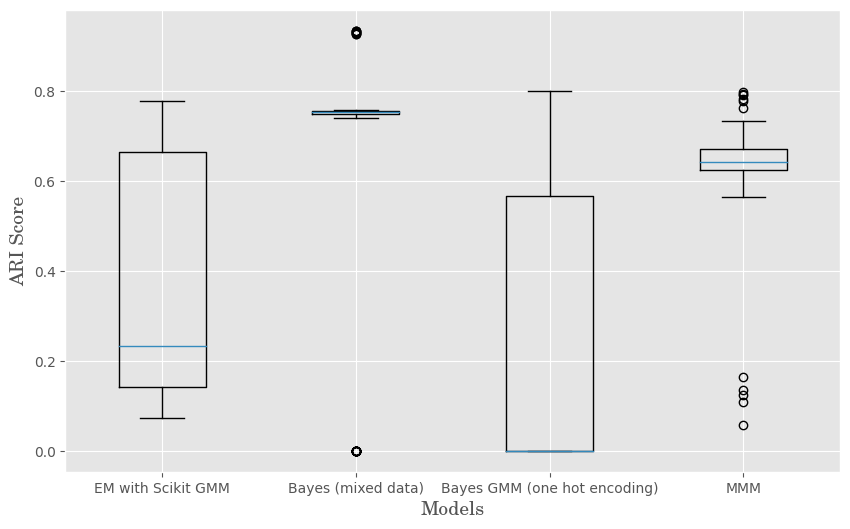

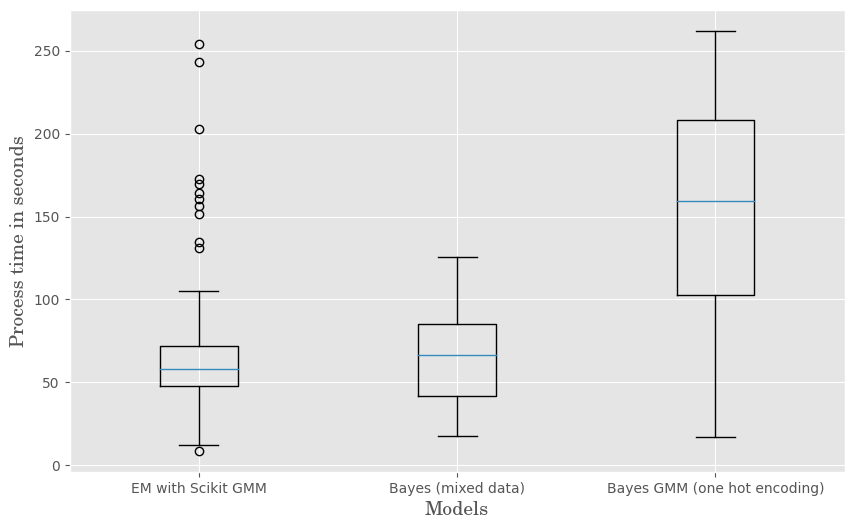

In [21]:


data = [ari['EM_diag'], ari['bayes'], ari['bayesGauss'], ari["MMM"]]
dataDF = pd.DataFrame(ari)
plt.figure(figsize=(10, 6))
# dataDF.boxplot(column=['EM', 'bayes', 'bayesGauss', "EM_diag", "MMM"])
plt.boxplot(data, labels = ["EM with Scikit GMM", "Bayes (mixed data)", "Bayes GMM (one hot encoding)", "MMM"])
# plt.title(f'ARI Comparison of Models for  N:{N} gD:{gD} cD:{cD} K:{K}')
plt.ylabel('ARI Score', fontdict={'fontsize': 14, 'fontfamily': 'C059'})
plt.xlabel('Models', fontdict={'fontsize': 14, 'fontfamily': 'C059'})
plt.savefig('thesis-results/catGauss_with_noise_boxplot_ari.png', dpi=300)
plt.show()
plt.close()


data = [process_time['EM'], process_time['bayes'], process_time['bayesGauss']]
dataDF = pd.DataFrame(process_time)
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels = ["EM with Scikit GMM", "Bayes (mixed data)", "Bayes GMM (one hot encoding)"])
plt.ylabel('Process time in seconds', fontdict={'fontsize': 14, 'fontfamily': 'C059'})
plt.xlabel('Models', fontdict={'fontsize': 14, 'fontfamily': 'C059'})
plt.savefig('thesis-results/catGauss_with_noise_boxplot_time.png', dpi=300)
plt.show()
plt.close()


In [48]:
# ##### Empty the model's data results directory with other results #######
# ###### USE CATIOUSLY ########

# import os

# def delete_files_without_string(directory, target_string):
#     for filename in os.listdir(directory):
#         if target_string not in filename:
#             file_path = os.path.join(directory, filename)
#             os.remove(file_path)
#             print(f"Deleted file: {file_path}")

# delete_files_without_string(f"{data_dir}", str(seed))